### SuperSpike 

This tutorial implements the SuperSpike learning rule with a simple network prototype with one pre-synaptic neuron and one post-synaptic neuron. The Lava Process Architecture is as shown below:

![SuperSpike_Architecture](SuperSpike_architecture.svg)

In [41]:
import numpy as np
import time as timing

from lava.proc.lif.process import LIF
from lava.proc.io.source import RingBuffer as SpikeIn
from lava.magma.core.learning.learning_rule import LoihiLearningRule
from lava.proc.dense.process import LearningDense, Dense
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg

#### Importing the SuperSpike Learning Rule Wrapper

![SuperSpike](SuperSpike_learning_rule.svg)

In [42]:
from lava.proc.learning_rules.SuperSpike_learning_rule import DoubleExponentialSuperSpikeLoihi

SuperSpike = DoubleExponentialSuperSpikeLoihi(learning_rate=0.000001,
                                              pre_synaptic_decay_tau=10,
                                              pre_synaptic_rise_tau=5,
                                              eligibility_trace_decay_tau=0.19,
                                              eligibility_trace_rise_tau=0.1,
                                              t_epoch=1
                                              )

#### Setting Simulation Parameters and Creating Input Spikes

In [43]:
SELECT_TAG = "floating_pt"

In [44]:
# General Params
num_rounds = 100
num_steps_single_presentation = 100
num_steps = num_rounds * num_steps_single_presentation

In [45]:
# ============================================================================================================
# PARAMS
# ============================================================================================================
# Neural Params
num_neurons_pre = 1
shape_lif_pre = (num_neurons_pre, )
du_pre = 1
dv_pre = 1
vth_pre = 0.99

num_neurons_post = 1
shape_lif_post = (num_neurons_post, )
du_post = 0.03
dv_post = 0.07
vth_post = 1

wgt_input_pre = np.eye(num_neurons_pre) * 1

shape_pre_post = shape_lif_post + shape_lif_pre
wgt_pre_post = np.full(shape_pre_post, 0.15)

wgt_reward_post = np.eye(num_neurons_post) * 1

np.random.seed(1523)
spike_prob = 0.03
spike_raster_pre = np.zeros((num_neurons_pre, num_steps_single_presentation), dtype=int)

#np.place(spike_raster_pre, np.random.rand(num_neurons_pre, num_steps_single_presentation) < spike_prob, 1)
spike_raster_pre[0, 40] = 1

spike_times_post_target = [54] 
spikes_raster_post_target = np.zeros((num_neurons_post, num_steps_single_presentation), dtype=int)
spikes_raster_post_target[0, spike_times_post_target] = 1
# ============================================================================================================
# ============================================================================================================

#### Creating a LearningDenseProbe for Measuring Trace Dynamics

_NOTE : This is workaround for simulation taking too long while using Monitor's_

In [46]:
from utils_SuperSpike import LearningDenseProbe, PyLearningDenseProbeModelFloat, SuperSpikeLIF, PySuperSpikeLifModelFloat

#### Lava Process Architecture

One pre-synaptic neuron is connected to one post-synaptic neuron. One plastic synapse is update via the 'SuperSpike' learning rule.

In [47]:
# Create input devices
pattern_pre = SpikeIn(data=spike_raster_pre)

# Create error signal input device
reward_pattern_post = SpikeIn(data=spikes_raster_post_target)

# Create input connectivity
conn_inp_pre = Dense(weights=wgt_input_pre)
conn_inp_reward = Dense(weights=wgt_reward_post)

# Create pre-synaptic neurons
lif_pre = LIF(u=0,
              v=0,
              du=du_pre,
              dv=dv_pre,
              bias_mant=0,
              bias_exp=0,
              vth=vth_pre,
              shape=shape_lif_pre,
              name='lif_pre')

# Create plastic connection
plast_conn = LearningDenseProbe(weights=wgt_pre_post,
                   learning_rule=SuperSpike,
                   name='plastic_dense')

# Create post-synaptic neuron
lif_post = SuperSpikeLIF(u=0,
               v=0,
               du=du_post,
               dv=dv_post,
               bias_mant=0,
               bias_exp=0,
               vth=vth_post,
               shape=shape_lif_post,
               learning_rule=SuperSpike,
               name='lif_post')

# Connect network
pattern_pre.s_out.connect(conn_inp_pre.s_in)
conn_inp_pre.a_out.connect(lif_pre.a_in)

# Reward ports
reward_pattern_post.s_out.connect(conn_inp_reward.s_in)
conn_inp_reward.a_out.connect(lif_post.a_third_factor_in)

lif_pre.s_out.connect(plast_conn.s_in)
plast_conn.a_out.connect(lif_post.a_in)

# Connect back-propagating action potential (BAP)
lif_post.s_out_bap.connect(plast_conn.s_in_bap)

# Connect reward trace callback (y2, y3)
lif_post.s_out_y1.connect(plast_conn.s_in_y1)
lif_post.s_out_y2.connect(plast_conn.s_in_y2)
lif_post.s_out_y3.connect(plast_conn.s_in_y3)

#### Custom Monitor Process and ProcessModel to Measure Trace State.

In [48]:
from utils_SuperSpike import MyMonitor, MyMonitorPM

In [49]:
monitor = MyMonitor(shape_pre=shape_lif_pre, 
                    shape_post=shape_lif_post, 
                    shape_learning_dense=shape_lif_post+shape_lif_pre, 
                    buffer_size=num_steps)

lif_pre.s_out.connect(monitor.pre_spikes_port)
lif_post.s_out.connect(monitor.post_spikes_port)
#lif_post.v_port.connect(monitor.lif_mem_voltage_port)

plast_conn.x1_port.connect(monitor.learning_dense_x1_port)
plast_conn.x2_port.connect(monitor.learning_dense_x2_port)
plast_conn.y2_port.connect(monitor.learning_dense_y2_port)
plast_conn.y3_port.connect(monitor.learning_dense_y3_port)
plast_conn.weights_port.connect(monitor.learning_dense_weights_port)
plast_conn.tag_1_port.connect(monitor.learning_dense_tag_1_port)
plast_conn.tag_2_port.connect(monitor.learning_dense_tag_2_port)

In [50]:
pattern_pre.run(condition=RunSteps(num_steps=num_steps), run_cfg=Loihi2SimCfg(select_tag=SELECT_TAG))

In [52]:
# Get data from monitors
pre_spikes = monitor.pre_spikes.get()[0][:, np.newaxis]

post_spikes = monitor.post_spikes.get()[0][:, np.newaxis]

pre_trace_decay = monitor.learning_dense_x1.get()[0][:, np.newaxis]
pre_trace_rise = monitor.learning_dense_x2.get()[0][:, np.newaxis]
y2_ = monitor.learning_dense_y2.get()[0][:, np.newaxis]
y3_ = monitor.learning_dense_y3.get()[0][:, np.newaxis]
weights = monitor.learning_dense_weights.get()[0, 0][:, np.newaxis]
tag = monitor.learning_dense_tag_1.get()[0, 0][:, np.newaxis]
delay = monitor.learning_dense_tag_2.get()[0, 0][:, np.newaxis]

In [53]:
pattern_pre.stop()

#### Results and Plotting

In [54]:
from utils_SuperSpike import plot_spikes, plot_time_series, plot_time_series_combo, plot_spikes_shorter

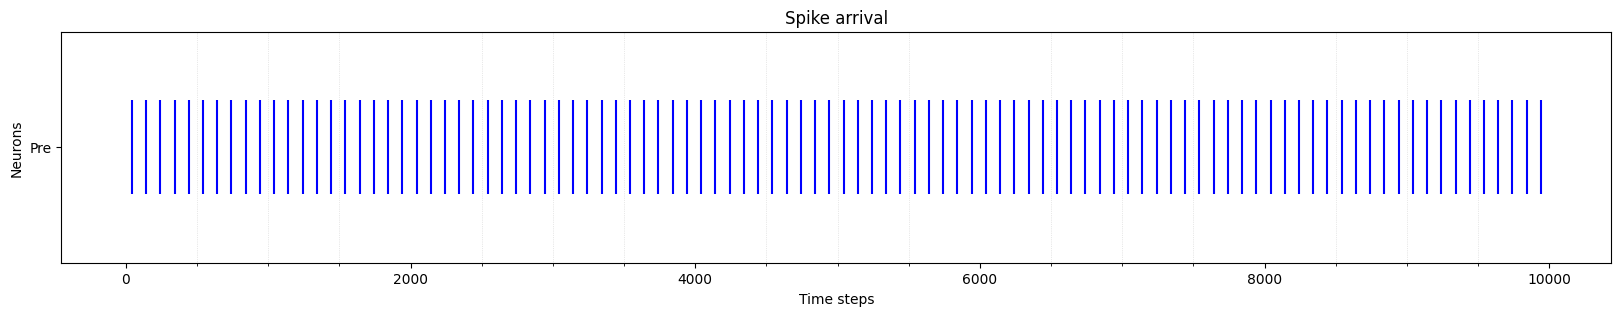

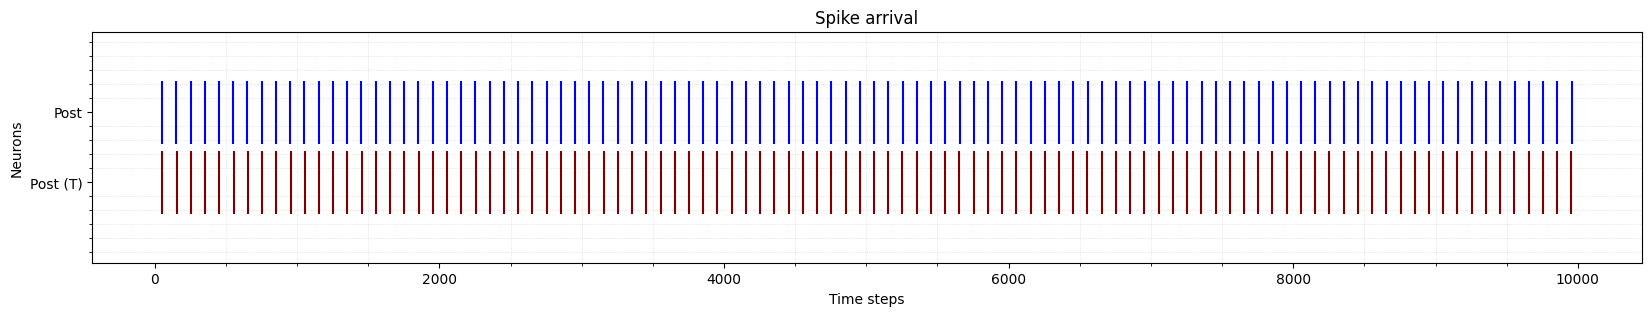

In [55]:
time = range(1, num_steps +1 )

# Plot spikes
plot_spikes(spikes=[np.where(pre_spikes[:, 0])[0]], 
            legend=['Pre'], 
            colors=['blue'])


# Plot spikes
plot_spikes(spikes=[np.where(np.tile(spikes_raster_post_target[0], num_rounds))[0], np.where(post_spikes[:, 0])[0]], 
            legend=['Post (T)', 'Post'], 
            colors=["maroon", 'blue'])

Difference of Exponential (x1-x2)


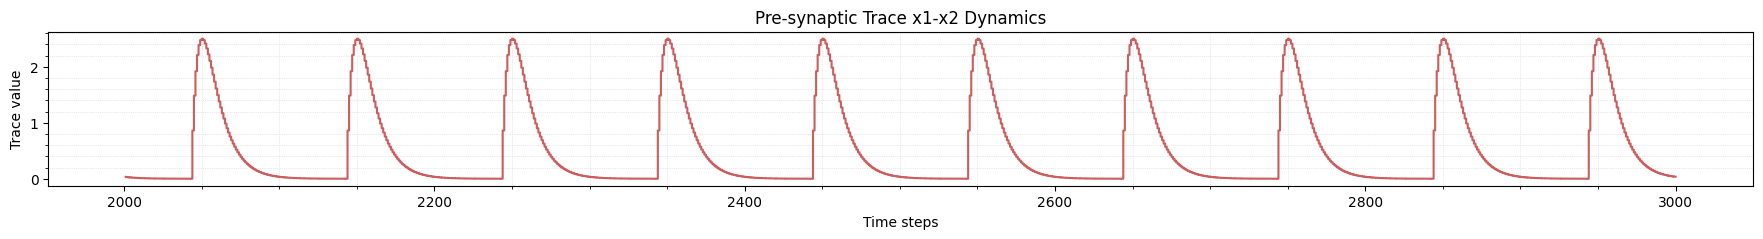

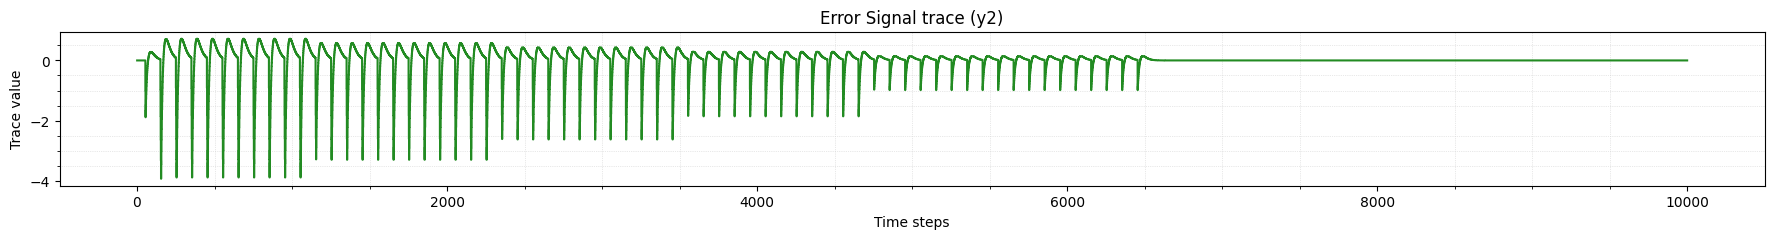

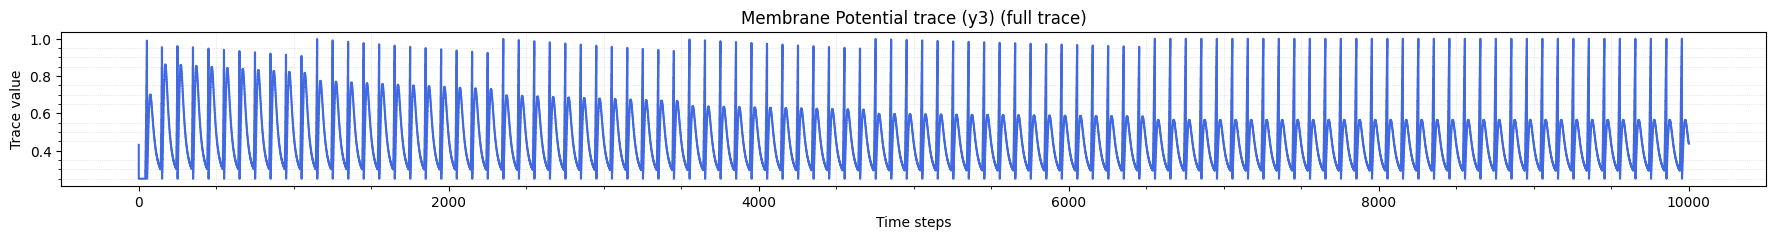

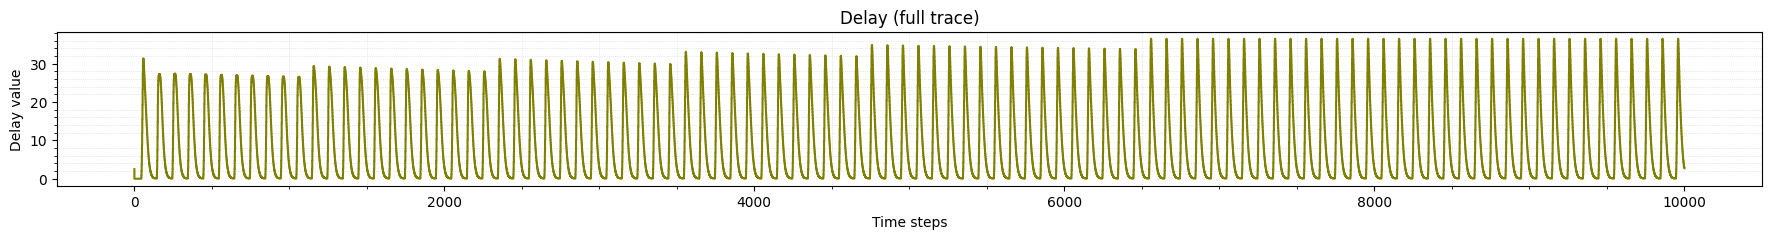

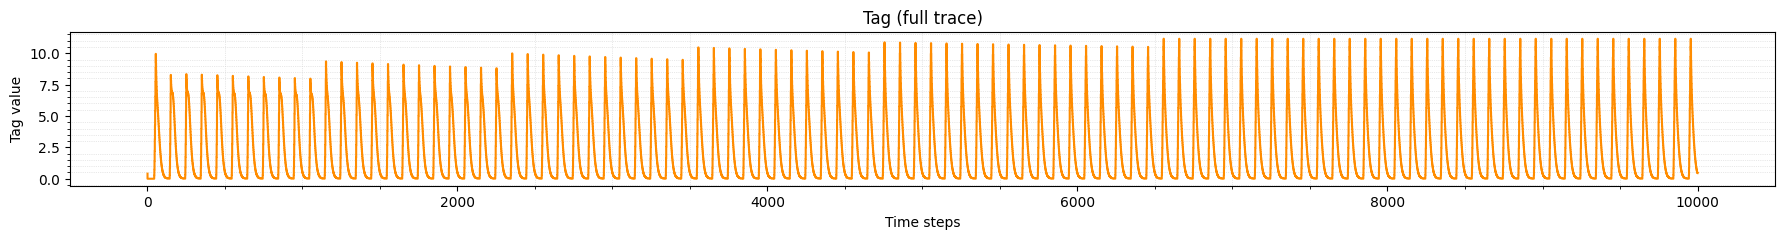

In [56]:
print("Difference of Exponential (x1-x2)")
x1_minus_x2 = pre_trace_decay - pre_trace_rise
plot_time_series(time=time[starting:ending], 
                 time_series=x1_minus_x2[starting:ending], 
                 ylabel="Trace value", 
                 title="Pre-synaptic Trace x1-x2 Dynamics", 
                 figsize=(22, 2), 
                 color='indianred')

plot_time_series(time=time, 
                 time_series=y2_, 
                 ylabel="Trace value", 
                 title="Error Signal trace (y2)", 
                 figsize=(22, 2), 
                 color='forestgreen')

plot_time_series(time=time, 
                 time_series=y3_, 
                 ylabel="Trace value", 
                 title="Membrane Potential trace (y3) (full trace)", 
                 figsize=(22, 2), 
                 color='royalblue')

plot_time_series(time=time, 
                 time_series=delay, 
                 ylabel="Delay value", 
                 title="Delay (full trace)", 
                 figsize=(22, 2), 
                 color='olive')

plot_time_series(time=time, 
                 time_series=tag, 
                 ylabel="Tag value", 
                 title="Tag (full trace)", 
                 figsize=(22, 2), 
                 color='darkorange')

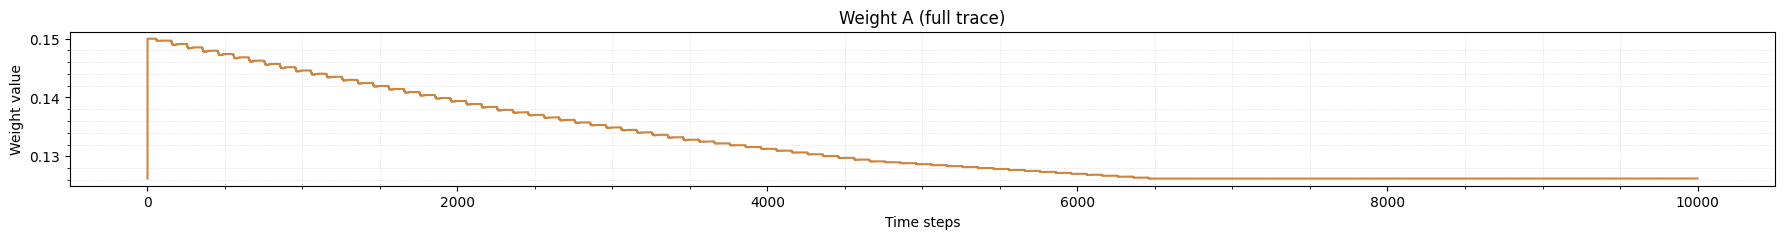

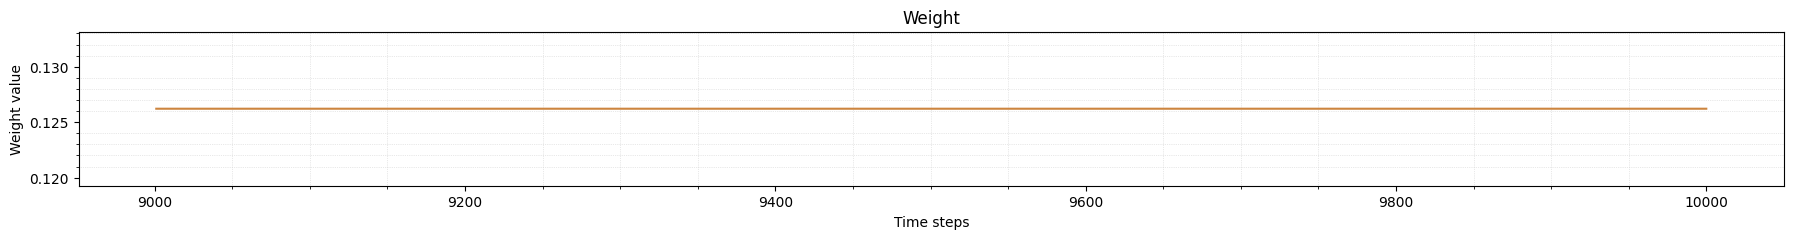

[  54  151  251  351  451  551  651  751  851  951 1051 1152 1252 1352
 1452 1552 1652 1752 1852 1952 2052 2152 2252 2353 2453 2553 2653 2753
 2853 2953 3053 3153 3253 3353 3453 3554 3654 3754 3854 3954 4054 4154
 4254 4354 4454 4554 4654 4755 4855 4955 5055 5155 5255 5355 5455 5555
 5655 5755 5855 5955 6055 6155 6255 6355 6455 6556 6656 6756 6856 6956
 7056 7156 7256 7356 7456 7556 7656 7756 7856 7956 8056 8156 8256 8356
 8456 8556 8656 8756 8856 8956 9056 9156 9256 9356 9456 9556 9656 9756
 9856 9956]
[  54  154  254  354  454  554  654  754  854  954 1054 1154 1254 1354
 1454 1554 1654 1754 1854 1954 2054 2154 2254 2354 2454 2554 2654 2754
 2854 2954 3054 3154 3254 3354 3454 3554 3654 3754 3854 3954 4054 4154
 4254 4354 4454 4554 4654 4754 4854 4954 5054 5154 5254 5354 5454 5554
 5654 5754 5854 5954 6054 6154 6254 6354 6454 6554 6654 6754 6854 6954
 7054 7154 7254 7354 7454 7554 7654 7754 7854 7954 8054 8154 8254 8354
 8454 8554 8654 8754 8854 8954 9054 9154 9254 9354 9454 9554 9654

In [65]:
plot_time_series(time=time, 
                 time_series=weights, 
                 ylabel="Weight value", 
                 title="Weight A (full trace)", 
                 figsize=(22, 2), 
                 color='peru')

plot_time_series(time=time[(num_steps-1000):num_steps], 
                 time_series=weights[starting:ending], 
                 ylabel="Weight value", 
                 title="Weight", 
                 figsize=(22, 2), 
                 color='peru')

print(np.where(post_spikes[:, 0])[0])
print(np.where(np.tile(spikes_raster_post_target[0], num_rounds))[0])
print(weights[num_steps-1])

In [61]:
# starting and ending time steps
# for targeted plotting
starting = num_steps - 1000
ending = num_steps

POST SPIKE TIMES   :  [9056, 9156, 9256, 9356, 9456, 9556, 9656, 9756, 9856, 9956]
TARGET SPIKE TIMES :  [9054, 9154, 9254, 9354, 9454, 9554, 9654, 9754, 9854, 9954] 

POST SPIKING WINDOW : 9000  to  10000


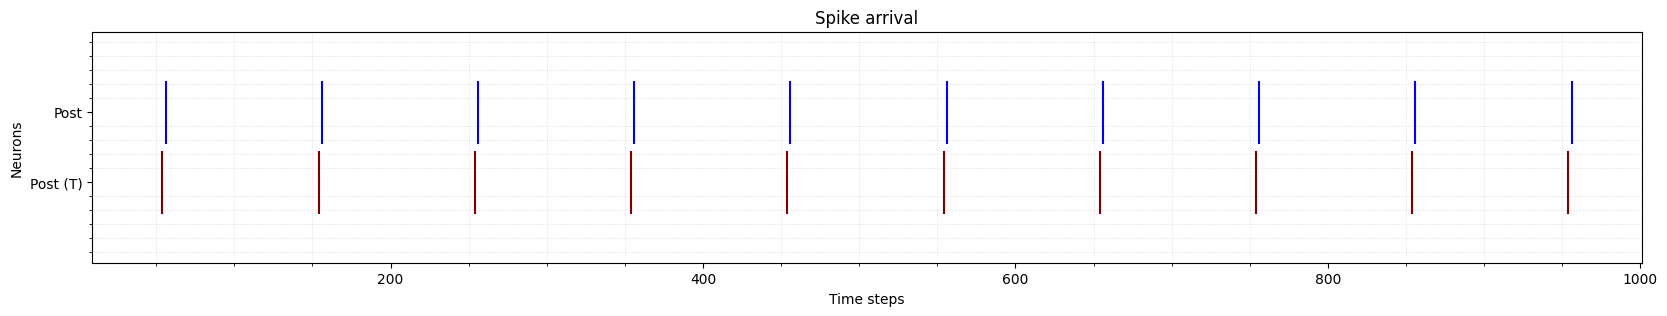

In [62]:
pre_spikes_output = []
pre_spike_output_range = np.where(pre_spikes_neuronA[:, 0])[0]
for po in pre_spike_output_range:
    if po in range(starting, ending+1):
        pre_spikes_output.append(po)

post_spikes_output = []
post_spike_output_range = np.where(post_spikes[:, 0])[0]
for po in post_spike_output_range:
    if po in range(starting, ending+1):
        post_spikes_output.append(po)

target_spike = []
target_spike_output = np.where(np.tile(spikes_raster_post_target[0], num_rounds))[0]
for to in target_spike_output:
    if to in range(starting, ending+1):
        target_spike.append(to)
        
print("POST SPIKE TIMES   : ", post_spikes_output)
print("TARGET SPIKE TIMES : ", target_spike, "\n")

# Plot spikes
print("POST SPIKING WINDOW :", starting, " to ", ending)
plot_spikes(spikes=[np.where(np.tile(spikes_raster_post_target[0], int(len(target_spike))))[0], np.where(post_spikes[starting:ending, 0])[0]], 
            legend=['Post (T)', 'Post'], 
            colors=["maroon", 'blue'],
            )

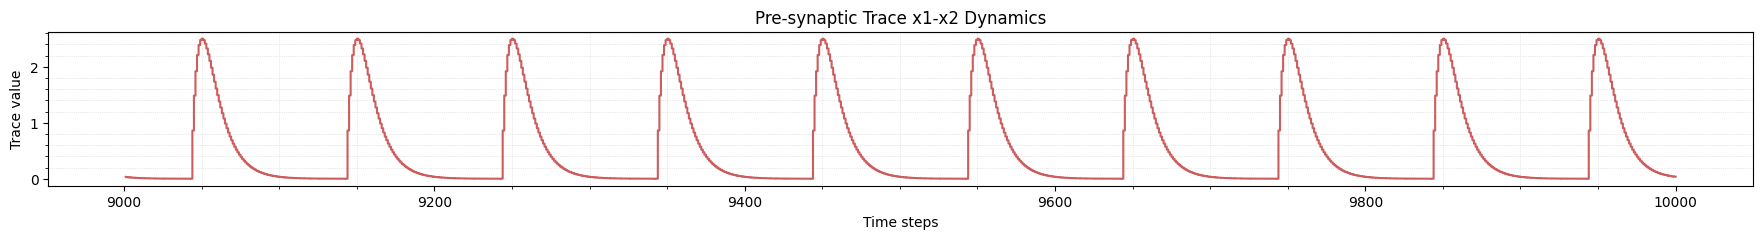

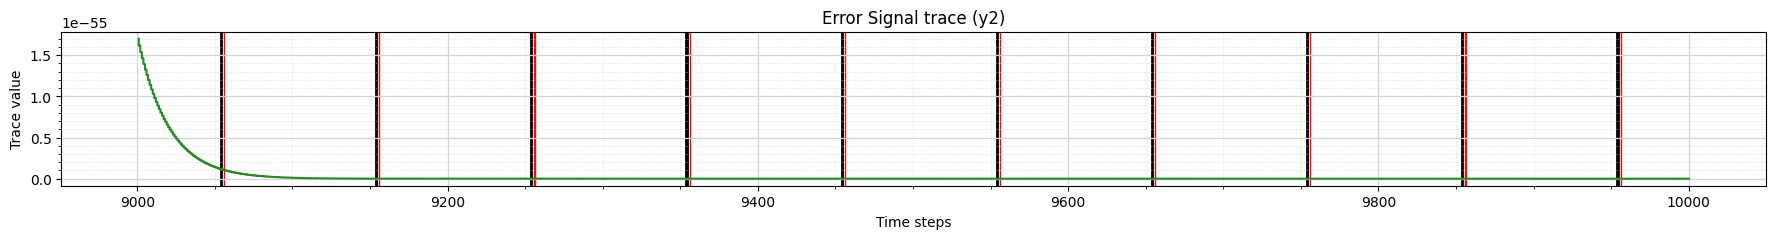

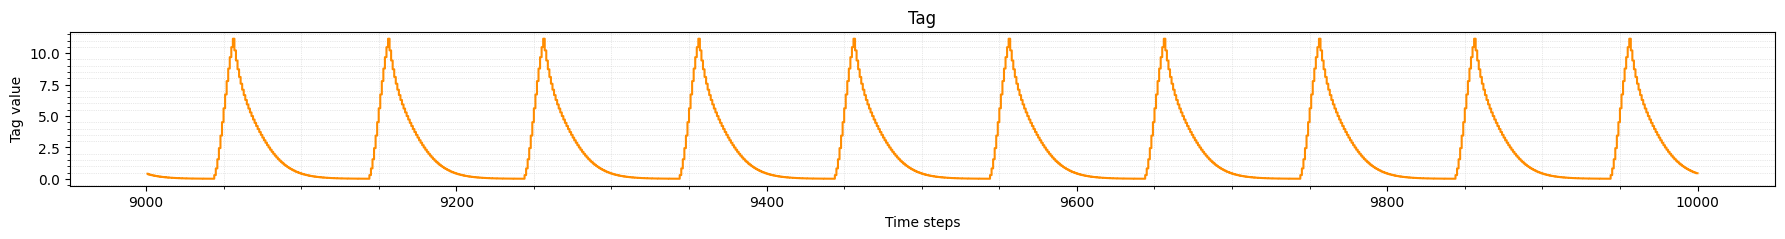

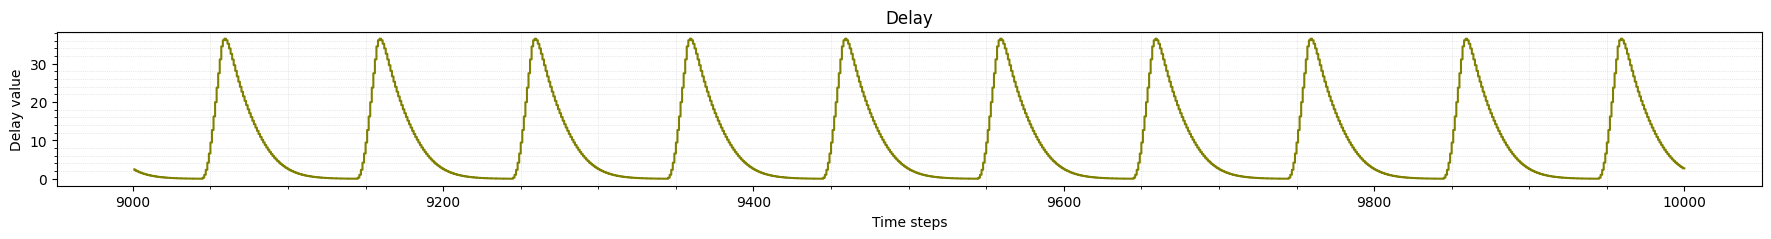

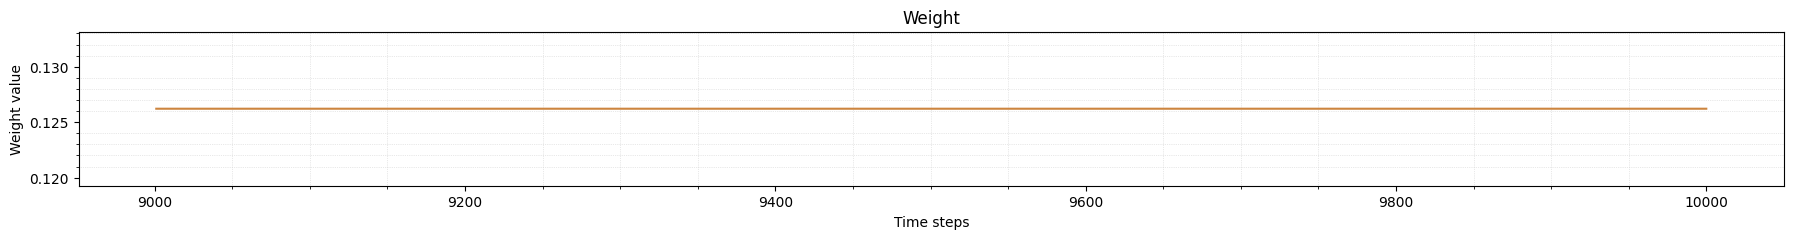

In [63]:
x1_minus_x2 = pre_trace_decay - pre_trace_rise
plot_time_series(time=time[starting:ending], 
                 time_series=x1_minus_x2[starting:ending], 
                 ylabel="Trace value", 
                 title="Pre-synaptic Trace x1-x2 Dynamics", 
                 figsize=(22, 2), 
                 color='indianred')

plot_time_series_combo(time=time[starting:ending], 
                       time_series=y2_[starting:ending], 
                       ylabel="Trace value", 
                       title="Error Signal trace (y2)", 
                       figsize=(22, 2), 
                       colors=['forestgreen','red', 'black'],
                       spikes=post_spikes_output,
                       spikes_target=target_spike,
                       target=True
                       )

plot_time_series(time=time[starting:ending], 
                 time_series=tag[starting:ending], 
                 ylabel="Tag value", 
                 title="Tag", 
                 figsize=(22, 2), 
                 color='darkorange')
                 
plot_time_series(time=time[starting:ending], 
                 time_series=delay[starting:ending], 
                 ylabel="Delay value", 
                 title="Delay", 
                 figsize=(22, 2), 
                 color='olive')

plot_time_series(time=time[starting:ending], 
                 time_series=weights[starting:ending], 
                 ylabel="Weight value", 
                 title="Weight", 
                 figsize=(22, 2), 
                 color='peru')

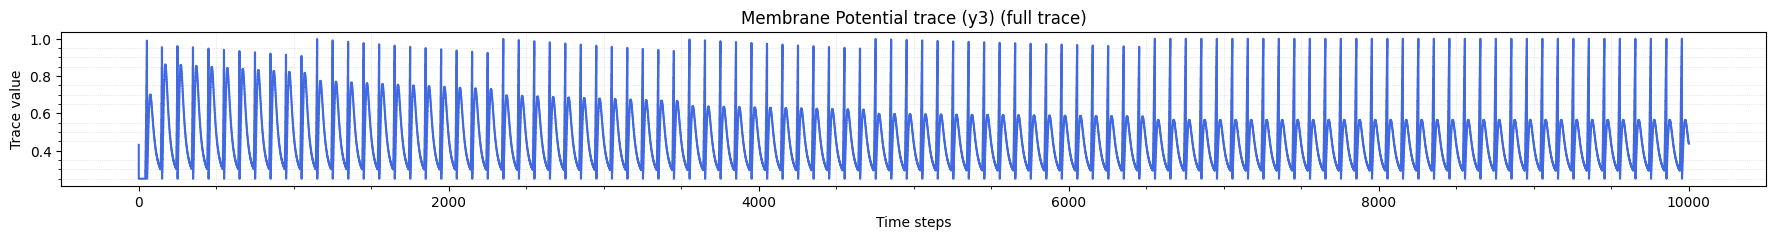

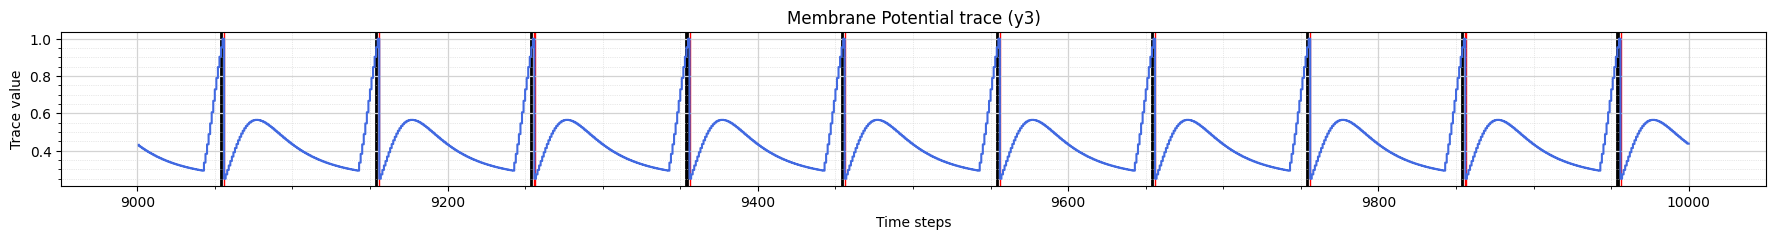

In [64]:
plot_time_series(time=time, 
                 time_series=y3_, 
                 ylabel="Trace value", 
                 title="Membrane Potential trace (y3) (full trace)", 
                 figsize=(22, 2), 
                 color='royalblue')

plot_time_series_combo(time=time[starting:ending], 
                       time_series=y3_[starting:ending], 
                       ylabel="Trace value", 
                       title="Membrane Potential trace (y3)", 
                       figsize=(22, 2), 
                       colors=['royalblue','red', 'black'],
                       spikes=post_spikes_output,
                       spikes_target=target_spike,
                       target=True
                       )

In [ ]:
plot_time_series(time=time, 
                 time_series=tag, 
                 ylabel="Tag value", 
                 title="Tag (full trace)", 
                 figsize=(22, 2), 
                 color='darkorange')

plot_time_series(time=time[starting:ending], 
                 time_series=tag[starting:ending], 
                 ylabel="Tag value", 
                 title="Tag", 
                 figsize=(22, 2), 
                 color='darkorange')


In [ ]:
plot_time_series(time=time, 
                 time_series=delay, 
                 ylabel="Delay value", 
                 title="Delay (full trace)", 
                 figsize=(22, 2), 
                 color='olive')

plot_time_series(time=time[starting:ending], 
                 time_series=delay[starting:ending], 
                 ylabel="Delay value", 
                 title="Delay", 
                 figsize=(22, 2), 
                 color='olive')

In [ ]:
plot_time_series(time=time, 
                 time_series=weights, 
                 ylabel="Weight value", 
                 title="Weight A (full trace)", 
                 figsize=(22, 2), 
                 color='peru')

plot_time_series(time=time[starting:ending], 
                 time_series=weights[starting:ending], 
                 ylabel="Weight value", 
                 title="Weight", 
                 figsize=(22, 2), 
                 color='peru')